In [3]:
'''
The purpose of this file is to implement and analyse the "Fast Simulation of Laplacian Growth"
proposed by Kim et al. (2007). So far I've implemented the electric potential calculation as 
in Niemeyer et al. (1984). I want to analyze the speedup I detect, and whether the results become 
quantitatively or qualitativele different.


Kim, T., Sewall, J., Sud, A., & Lin, M. C. (2007). 
    Fast Simulation of Laplacian Growth. IEEE Computer Graphics and Applications, 27(2), 68–76. 
    https://doi.org/10.1109/mcg.2007.33
    https://gamma.cs.unc.edu/FRAC/laplacian_large.pdf

Niemeyer, L., Pietronero, L., & Wiesmann, H. (1984). 
    Fractal Dimension of Dielectric Breakdown. Physical Review Letters, 52(12), 1033–1036. 
    https://doi.org/10.1103/physrevlett.52.1033
''';

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

In [4]:
# Original implementation, repeated diffusion to approximate laplace solution. (Niemeyer et al., 1984)

class lightningSimulation:
    def __init__(self,
                 width=80,
                 height=80,
                 n=1.2,
                 rod_height=0,
                 rod_xpos=0.5,
                 debug=False,
                 threshold = 0.0001,
                 neighborhood_type = ''):

        # Store grid dimensions
        self.width = width
        self.height = height

        # Create grid and set all to -1
        self.grid = np.ones(shape=(height, width))
        self.grid *= -1

        # The lightning downwards-tendency parameter
        self.n = n

        # Number of update steps
        self.steps = 0

        # To debug or not
        self.debug = debug
        self.display_interval = 75

        # The current electric potential
        self.potential = self.grid

        # Lightning distance to ground
        self.dist_to_ground = self.height

        self.struck_ground = False

        self.threshold = threshold

        self.difference_per_conv = []
        self.overall_sum = []

        # Neighborhood types
        diagonal_neighbors = [(1, 1), (-1, 1), (1, -1), (-1, -1)]
        neumann_neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        moore_neighbors = diagonal_neighbors.copy()
        moore_neighbors.extend(neumann_neighbors)

        if neighborhood_type == 'diagonal':
            self.neighborhood_type = diagonal_neighbors
        elif neighborhood_type == 'moore':
            self.neighborhood_type = moore_neighbors
        elif neighborhood_type == 'neumann':
            self.neighborhood_type = neumann_neighbors
        else:
            self.neighborhood_type = neumann_neighbors

        self.initial_electric_pot()

        self.setup_environment(rod_height, rod_xpos)


    def setup_environment(self, rod_height=0, rod_xpos=0.5):
        '''
        Creates the enviroment of
            1. lightning start position, where self.grid == 0
            2. cells which are considered ground, where self.grid == 1
        Unkown electric potential is where self.grid == -1
        '''

        # Potential of 1 represents ground
        # Set ground to potential 1
        self.grid[-1, :] = 1
        for i in range(rod_height):
            self.grid[-1-i, int(self.width*rod_xpos)] = 1

        # Potential of 0 represents lightning structure
        self.grid[0, self.width//2] = 0
        self.newest_neighbor = (0, int(self.width*rod_xpos))

        self.update_electric_pot(self.newest_neighbor)



    def display_state(self, this_grid=None, lightning=False):
        # Plot a figure displaying the environment
        if this_grid is None:
            this_grid = self.grid

        # If display lightning
        if lightning:
            # Display 0 potentials as yellow
            masked_arr = np.ma.masked_where(this_grid == 0, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='yellow')
        else:
            # Otherwise it's plotting potential
            # Otherwise set -1 as gray
            masked_arr = np.ma.masked_where(this_grid == -1, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='gray')

        # Display
        plt.figure(figsize=(16, 10))
        plt.imshow(masked_arr, cmap=cmap)
        plt.colorbar()

        if not lightning:
            plt.contour(this_grid, colors='white')
        plt.show()

    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.height, desc="How close the lightning is to the ground", unit="cells")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.height - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.height - self.newest_neighbor[0]
                    progress_bar.update(1)

    def check_struck_ground(self):
        # Look at all neighbors of newest neighbor
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            if self.newest_neighbor[0] > 5:
                # If within bounds
                if self.newest_neighbor[0]+dy > 0 and self.newest_neighbor[0]+dy < self.height and self.newest_neighbor[1]+dx > 0 and self.newest_neighbor[1]+dx < self.width:
                    # If one neighbor is ground (potential 1), break while loop
                    if self.grid[self.newest_neighbor[0]+dy, self.newest_neighbor[1]+dx] == 1:
                        self.struck_ground = True

    def update(self):

        # Debug
        if self.debug and self.steps % self.display_interval == 0:
            print("The lightning structure")
            self.display_state(lightning=True)

        # Keep track of neighbors
        neighbors = {}
        # For each cell
        for x in range(self.width):
            for y in range(self.height):
                # If this cell is part of the lightning structure
                if self.grid[y, x] == 0:
                    # For each neighbor
                    for dy, dx in self.neighborhood_type:
                        # If neighbor is within bounds
                        if y+dy >= 0 and y+dy < self.height and x+dx >= 0 and x+dx < self.width:
                            # If neighbor hasn't been counted before and it's not a part of the lightning
                            if (y+dy, x+dx) not in neighbors.keys() and self.grid[y+dy, x+dx] != 0:
                                # Add their electric potential to dictionary
                                neighbors[(y+dy, x+dx)] = self.potential[y+dy, x+dx]



        # Raise each weight to the power of n
        weights = [val**self.n for val in neighbors.values()]
        # Ensure they sum up to 1
        #weights = np.array(weights)/np.sum(weights)
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(neighbors.keys()), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.newest_neighbor = chosen_cell

        self.update_electric_pot(self.newest_neighbor)

        self.check_struck_ground()

        self.steps += 1


    def initial_electric_pot(self):
        gradient = np.linspace(1/self.height, 1, self.height)

        # Reshape the gradient to match the dimensions of the array
        gradient = gradient[:, np.newaxis]

        # Tile the gradient to match the width of the array
        gradient = np.tile(gradient, (1, self.width))

        self.potential = gradient


    def update_electric_pot(self, pos):
        '''
        Calculates the unknown electric potential in the air
        by estimating the discrete solution to the 2D laplace
        equation (∇^2f = 0), which corresponds to the partial
        second derivatives being 0 everywhere. Intuitively it
        means that the electric potential changes smoothly everywhere.

        This is approximated by repeating diffusion over the grid,
        using a von Neumann kernel.
        '''

        # Remove the potential
        self.potential[pos[0], pos[1]] = 0

        # Set it as a fixed cell
        self.grid[pos[0], pos[1]] = 0

        # Update the rest of the potential
        self.potential = self.iterative_diffusion()



    def iterative_diffusion(self):

        # Kernel I perform convolutions with, takes the average of von Neumann neighborhood
        kernel = np.array([[0,1/4,0],[1/4,0,1/4],[0,1/4,0]])


        old_diffused = self.potential
        old_diffused = np.pad(old_diffused, 1, mode='constant')

        # Make ground and lightning structure fixed
        no_change_mask = (np.pad(self.grid, 1, mode='constant') != -1)

        # Set newly padded sides of grid to the a linear increase
        # This emulates that the electric potential is uniform outside scope of grid
        old_diffused[:,0] = np.linspace(0, 1, self.height+2)
        old_diffused[:,-1] = np.linspace(0, 1, self.height+2)

        # Set unknown potentials, to update, to zero
        old_diffused[old_diffused == -1] = 0

        while True:

          # Convolve over entire grid
          diffused_grid = convolve(old_diffused, kernel, mode='constant', cval=1.0)

          # Reset the cells that shouldn't change
          diffused_grid[no_change_mask] = old_diffused[no_change_mask]


          self.difference_per_conv.append(np.sum(abs(np.array(diffused_grid) - np.array(old_diffused))))
          self.overall_sum.append(np.sum(np.array(diffused_grid)))

          if np.sum(abs(np.array(diffused_grid) - np.array(old_diffused))) < self.threshold:
            break

          old_diffused = diffused_grid

        # Remove padding
        diffused_grid = diffused_grid[1:-1,1:-1]

        if self.steps % self.display_interval == 0 and self.debug:
            print("The diffusion")
            self.display_state(self.potential)

        return diffused_grid

In [65]:
sim_instance = lightningSimulation(width=80, height=80, n=1.5, threshold=0.001)

for _ in tqdm(range(100)):
    sim_instance.update()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


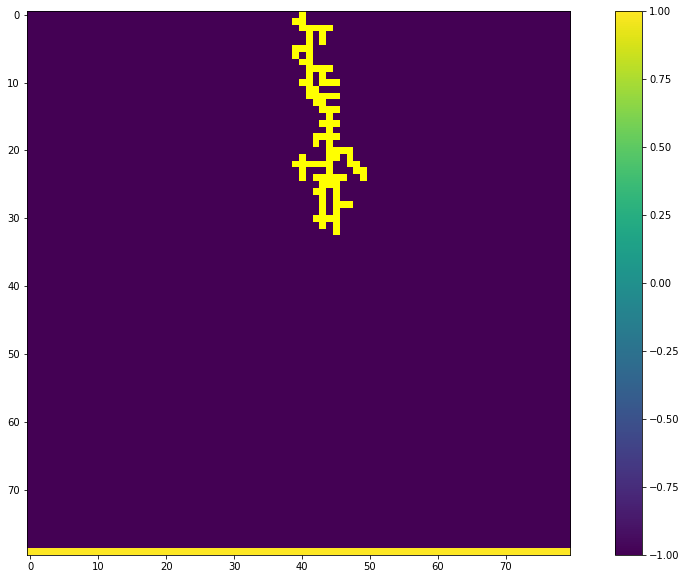

In [66]:
sim_instance.display_state(lightning=True)

  0%|                                                                                           | 0/80 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 530.63it/s]


[([0, 40], 1), ([1, 39], 1), ([1, 40], 1), ([2, 40], 1), ([2, 41], 1), ([2, 42], 1), ([2, 43], 1), ([2, 44], 1), ([3, 41], 1), ([3, 43], 1), ([4, 41], 1), ([4, 43], 1), ([5, 39], 1), ([5, 40], 1), ([5, 41], 1), ([6, 39], 1), ([6, 41], 1), ([7, 40], 1), ([7, 41], 1), ([8, 41], 1), ([8, 42], 1), ([8, 43], 1), ([8, 44], 1), ([9, 41], 1), ([9, 43], 1), ([10, 40], 1), ([10, 41], 1), ([10, 43], 1), ([10, 44], 1), ([10, 45], 1), ([11, 41], 1), ([11, 42], 1), ([12, 41], 1), ([12, 42], 1), ([12, 43], 1), ([12, 44], 1), ([12, 45], 1), ([13, 42], 1), ([13, 43], 1), ([14, 43], 1), ([14, 44], 1), ([14, 45], 1), ([15, 44], 1), ([16, 43], 1), ([16, 44], 1), ([16, 45], 1), ([17, 44], 1), ([18, 42], 1), ([18, 43], 1), ([18, 44], 1), ([18, 45], 1), ([19, 42], 1), ([19, 44], 1), ([20, 44], 1), ([20, 45], 1), ([20, 46], 1), ([20, 47], 1), ([21, 40], 1), ([21, 44], 1), ([21, 45], 1), ([21, 47], 1), ([22, 39], 1), ([22, 40], 1), ([22, 41], 1), ([22, 42], 1), ([22, 43], 1), ([22, 44], 1), ([22, 47], 1), ([22

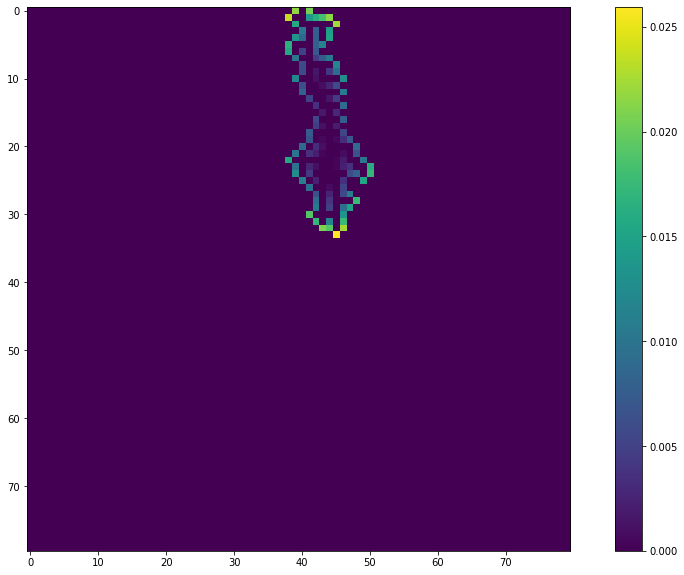

In [82]:
# Calculate potential at lightning neighbors using fast method (Kim et al., 2007)

# Find each candidate cell (neighbors), search brute force for consistency (left to right, then up to down)
candidates = []
lightning_struct = []
for row_i in tqdm(range(sim_instance.height)):
    for x_i in range(sim_instance.width):
        # If not part of ligthning
        if sim_instance.grid[row_i, x_i] == -1:
            neighbor_is_lightning = False
            # For each neighbor
            for diff in [[1,0], [-1,0], [0,1], [0,-1]]:
                neigh_pos = np.array([row_i, x_i]) + np.array(diff)
                # if within bounds
                if neigh_pos[0] >= 0 and neigh_pos[0] < sim_instance.height and neigh_pos[1] >= 0 and neigh_pos[1] < sim_instance.width:
                    # If neighbor is lightning
                    if sim_instance.grid[neigh_pos[0], neigh_pos[1]] == 0:
                        candidates.append([row_i, x_i])
                        break
        # If part of lightning
        elif sim_instance.grid[row_i, x_i] == 0:
            lightning_struct.append(([row_i, x_i], 1))
        # If part of ground
        # This step diverts from the paper, which consider the ground
        # to be infinitely far away in each direction.abs
        # I technically also consider this, but I let 
        # my my "ground" be a line of opposite charge particles.
        elif sim_instance.grid[row_i, x_i] == 1:
            lightning_struct.append(([row_i, x_i], -1))


print(lightning_struct)
print(candidates)
potentials = []

# Calculate potential for each candidate
for candidate in candidates:
    tot = 0
    for charge_data in lightning_struct:
        charge_pos = charge_data[0]
        diff = np.array(candidate)-np.array(charge_pos)
        dist = np.sum(diff**2)**0.5
        tot += (1 - .5/(dist))*charge_data[1]
    potentials.append(tot)

print(potentials)

# Normalize the potentials and use nu
nu = 1.5
min_pot = min(potentials)
pot_range = max(potentials) - min(potentials)

probabilities = []
# Normalize
for i in range(len(potentials)):
#    probabilities.append( ( potentials[i] - min_pot ) / (pot_range) )
    probabilities.append(potentials[i] - min_pot)

print(probabilities)

# Make probability distribution, raising to the power of nu
raised_sum = np.sum(np.array(probabilities)**nu)
for i in range(len(probabilities)):
    probabilities[i] = probabilities[i]**nu / raised_sum

print(probabilities)


# Plotting
probabilities_arr = np.zeros((sim_instance.height, sim_instance.width))

for i, pos in enumerate(candidates):
    probabilities_arr[pos[0], pos[1]] = probabilities[i]


cmap = matplotlib.cm.viridis

plt.figure(figsize=(16, 10))
plt.imshow(probabilities_arr, cmap=cmap)
plt.colorbar()
plt.show()

[0.0001732747755379823, 1.3017929237974876e-05, 0.0013750922387498648, 1.3851612560538565e-05, 4.238842642258729e-05, 0.0001174819872972395, 0.0003300649255110078, 0.000967218122734317, 0.0013808685561672415, 0.0005059472083713247, 2.070785596571474e-05, 0.0008597099607123137, 0.0014579668992182604, 0.000490979723180318, 8.283142283300181e-05, 0.0013575709983202453, 0.004178397529185496, 0.00031061726842899595, 0.0007767014560755848, 0.0052013424639193746, 0.0, 0.0003829361793980121, 0.0031147142022781545, 0.000267467211976288, 0.0006869326552280698, 0.001526601109371654, 0.0018116322915303928, 0.002907639825275671, 0.0020653191719087185, 0.0, 0.0005766018814722756, 0.002306407497280556, 0.007323001877988244, 0.0, 0.005326492233391663, 0.0040098459833705045, 0.0001024176104482037, 0.0004096697504753584, 0.0015362613708857456, 0.006301293532264462, 0.005703349398351975, 0.0038585067731465622, 0.00041448175325049455, 0.001657926991903793, 0.0025527500620347943, 0.006102850840739484, 0.00

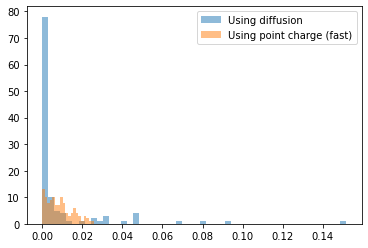

In [93]:
sim_instance.iterative_diffusion()
diffusion_potentials = []
for candidate in candidates:
    diffusion_potentials.append(sim_instance.potential[candidate[0], candidate[1]])

print(diffusion_potentials)

diffusion_probabilities = []
# Make probability distribution, raising to the power of nu
raised_sum = np.sum(np.array(diffusion_potentials)**nu)
for i in range(len(diffusion_potentials)):
    diffusion_probabilities.append( diffusion_potentials[i]**nu / raised_sum )

print(probabilities)
print(sum(probabilities))
print(max(probabilities))
print(diffusion_probabilities)
print(sum(diffusion_probabilities))
print(max(diffusion_probabilities))

plt.hist(diffusion_probabilities, bins=50, alpha=0.5, label='Using diffusion')
plt.hist(probabilities, bins=20, alpha=0.5, label='Using point charge (fast)')
plt.legend()
plt.show()